### I. INTRODUCTION
   *Name: Nurfiah Idris*  
   *Batch: 005*

**Data Set Information:**  

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The dataset constains of 41188 instances and 21 columns. More information of the dataset can be accessed [here]("https://archive.ics.uci.edu/ml/datasets/Bank+Marketing").

### II. LIBARARY

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

### III. DATA LOADING

In [2]:
# Load data.
df = pd.read_csv("/Users/nurfiahidris/Desktop/DS-Hacktiv8/Hacktiv8-Assignment/P1/Milestone01/bank-additional-full.csv",delimiter=";")
df.shape

(41188, 21)

### IV. DATA CLEANING

In [3]:
# Get first five instances of data
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Get dataset general information.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# Dataset description.
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Handle Missing Values**

In [6]:
# Find missing points.
missing_points = df.isnull().sum()/df.shape[0]*100
missing_points

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

We have no missing points on the dataset, no further action needed.

### V. DATA EXPLORATION

In [7]:
# List of categorical column name
col_cat = list(df.select_dtypes('object').columns)
print(f"Categorical column: {col_cat}")

# List of numerical column name
col_num = list(df.select_dtypes('number').columns)
print(f"Numerical column: {col_num}")

Categorical column: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Numerical column: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [8]:
# Find all unique value on categorical column.
for col in col_cat:
    print(f"{col}: {list(df[col].unique())}")

job: ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'retired', 'management', 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']
marital: ['married', 'single', 'divorced', 'unknown']
education: ['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree', 'illiterate']
default: ['no', 'unknown', 'yes']
housing: ['no', 'yes', 'unknown']
loan: ['no', 'yes', 'unknown']
contact: ['telephone', 'cellular']
month: ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr', 'sep']
day_of_week: ['mon', 'tue', 'wed', 'thu', 'fri']
poutcome: ['nonexistent', 'failure', 'success']
y: ['no', 'yes']


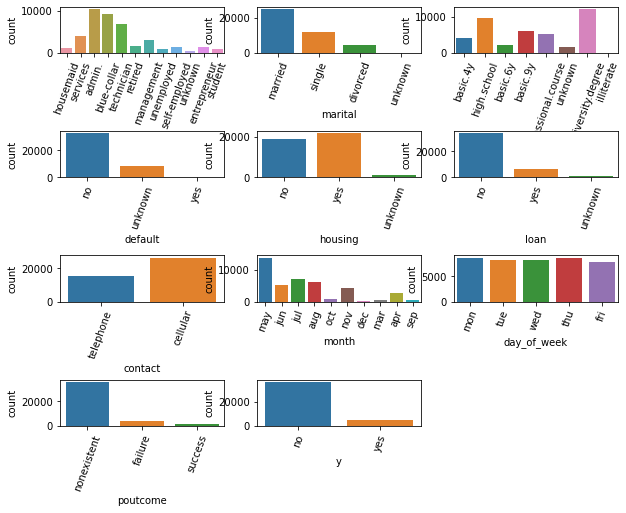

In [9]:
# Display categorical column on countplot
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=1.7)
for i, col in enumerate(df.select_dtypes('object')):
    ax = plt.subplot(5,3,i+1)
    plt.xticks(rotation = 70)
    sns.countplot(data=df, x=col)

Seems like we have some column with unknow value. We will drop all rows with unknow value where the unknow value of each columns it's not more than 50% as consideration.

In [10]:
# Drop rows with unknown values.
for col in col_cat:
    df = df.drop(df[df[col] == 'unknown'].index)
df.shape

(30488, 21)

Another categorical column that we will drop is poutcome column seeing that most of the instances is nonexistent class, means that most of the data is new subject that did't exist on the campaign in the past

In [11]:
# Drop poutome column.
df.drop('poutcome', axis=1,inplace=True)

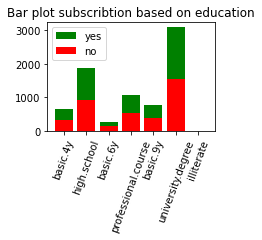

In [12]:
# Plot y column over education

education = list(df['education'].unique())

plt.figure(figsize=[3,2])
for i in range(len(education)):
    plt.bar(education[i],df[(df['education'] == education[i]) & (df['y'] == 'yes')].shape[0],bottom=df[df['education'] == education[i]].shape[0] - df[(df['education'] == education[i]) & (df['y'] == 'no')].shape[0],color= 'g')
    plt.bar(education[i],df[df['education'] == education[i]].shape[0] - df[(df['education'] == education[i]) & (df['y'] == 'no')].shape[0],color= 'r')
plt.legend(labels =['yes','no'])
plt.title("Bar plot subscribtion based on education")
plt.xticks(rotation=70)
plt.show()

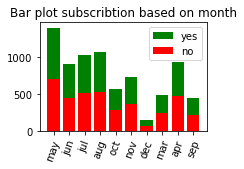

In [13]:
# Plot y column over month column
month = list(df['month'].unique())
plt.figure(figsize=[3,2])
for i in range(len(month)):
    plt.bar(month[i],df[(df['month'] == month[i]) & (df['y'] == 'yes')].shape[0],bottom=df[df['month'] == month[i]].shape[0] - df[(df['month'] == month[i]) & (df['y'] == 'no')].shape[0],color= 'g')
    plt.bar(month[i],df[df['month'] == month[i]].shape[0] - df[(df['month'] == month[i]) & (df['y'] == 'no')].shape[0],color= 'r')
plt.legend(labels =['yes','no'])
plt.title("Bar plot subscribtion based on month")
plt.xticks(rotation=70)
plt.show()

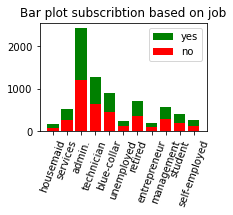

In [14]:
# Plot y column over job column
job = list(df['job'].unique())
plt.figure(figsize=[3,2])
for i in range(len(job)):
    plt.bar(job[i],df[(df['job'] == job[i]) & (df['y'] == 'yes')].shape[0],bottom=df[df['job'] == job[i]].shape[0] - df[(df['job'] == job[i]) & (df['y'] == 'no')].shape[0],color= 'g')
    plt.bar(job[i],df[df['job'] == job[i]].shape[0] - df[(df['job'] == job[i]) & (df['y'] == 'no')].shape[0],color= 'r')
plt.legend(labels =['yes','no'])
plt.title("Bar plot subscribtion based on job")
plt.xticks(rotation=70)
plt.show()

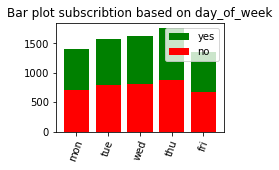

In [15]:
# Plot y column over day_of_week column
day_of_week = list(df['day_of_week'].unique())
plt.figure(figsize=[3,2])
for i in range(len(day_of_week)):
    plt.bar(day_of_week[i],df[(df['day_of_week'] == day_of_week[i]) & (df['y'] == 'yes')].shape[0],bottom=df[df['day_of_week'] == day_of_week[i]].shape[0] - df[(df['day_of_week'] == day_of_week[i]) & (df['y'] == 'no')].shape[0],color= 'g')
    plt.bar(day_of_week[i],df[df['day_of_week'] == day_of_week[i]].shape[0] - df[(df['day_of_week'] == day_of_week[i]) & (df['y'] == 'no')].shape[0],color= 'r')
plt.legend(labels =['yes','no'])
plt.title("Bar plot subscribtion based on day_of_week")
plt.xticks(rotation=70)
plt.show()

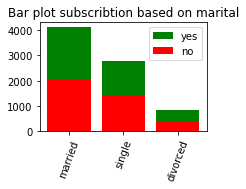

In [16]:
# Plot y column over marital

marital = list(df['marital'].unique())

plt.figure(figsize=[3,2])
for i in range(len(marital)):
    plt.bar(marital[i],df[(df['marital'] == marital[i]) & (df['y'] == 'yes')].shape[0],bottom=df[df['marital'] == marital[i]].shape[0] - df[(df['marital'] == marital[i]) & (df['y'] == 'no')].shape[0],color= 'g')
    plt.bar(marital[i],df[df['marital'] == marital[i]].shape[0] - df[(df['marital'] == marital[i]) & (df['y'] == 'no')].shape[0],color= 'r')
plt.legend(labels =['yes','no'])
plt.title("Bar plot subscribtion based on marital")
plt.xticks(rotation=70)
plt.show()

We will just drop the column day_of_week and marital column since it's distibution on the barplot above mostly similar from each others. 

In [17]:
# Drop day column.
df.drop('day_of_week', axis=1, inplace=True)
df.drop('marital', axis=1, inplace=True)

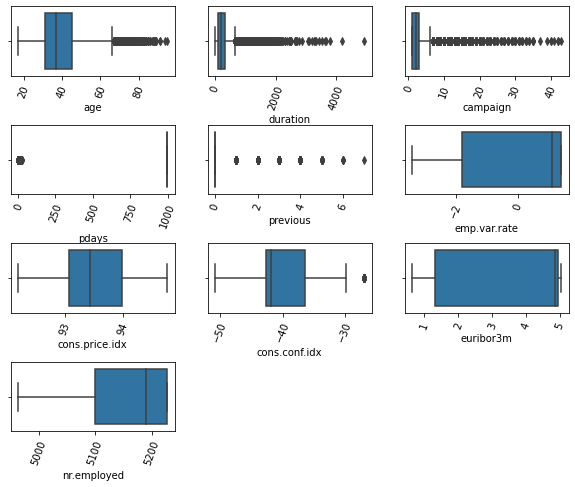

In [18]:
# Display numerical column on boxplot
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.7)
for i, col in enumerate(df.select_dtypes('number')):
    ax = plt.subplot(5,3,i+1)
    plt.xticks(rotation = 70)
    sns.boxplot(data = df, x=col)

We will have a deep look on previous and pdays column since it seems like have imbalance value.

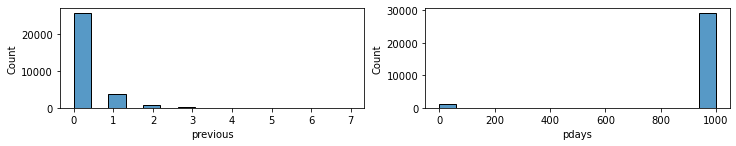

In [19]:
# Displat histogram of previous column
plt.figure(figsize=(12,15))
for i, col in enumerate(df[['previous','pdays']]):
    ax = plt.subplot(7,2,i+1)
    sns.histplot(df, x=col)

We are going to tranform both above columns into categorical:
- Previous: 0 values will be replaced as False (no contact performed before campaign) and others value will be True (there is contact performed before campaign regardless hom many contact had performed).
- Pdays: 999 values will be replaced as False (client was not previously contacted from a previous campaign) and others will be True (client was previously contacted from a previous campaign regardless number of days that passed by after the client was last contacted from a previous campaign).

In [20]:
# Replace the value on previous column.
df.loc[df['previous'] == 0, 'previous'] = 0 
df.loc[df['previous'] != 0, 'previous'] = 1 

# Replace the value on pdays column.
df.loc[df['pdays'] != 999, 'pdays'] = 1 
df.loc[df['pdays'] == 999, 'pdays'] = 0 
    

Now, let's transform all caterical column which has only two unique number (yes/no) to be numerical in order to have access on seeing the correlation with target column.

In [21]:
# Transform yes/no column categoric to numeric.
for col in df.select_dtypes('object'):
    if len(df[col].unique()) == 2:
        df[col] = df[col].replace(['yes','no'],[1,0])
# Transform contact column categoric to numeric.    
df['contact'] = df['contact'].replace(['telephone','cellular'],[1,0])
df.sample()

,age,job,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
36677,21,student,university.degree,0,0,0,0,jun,493,2,0,0,-2.9,92.963,-40.8,1.268,5076.2,1


In [22]:
# Find correlation
df_corr = df.corr()

<AxesSubplot:>

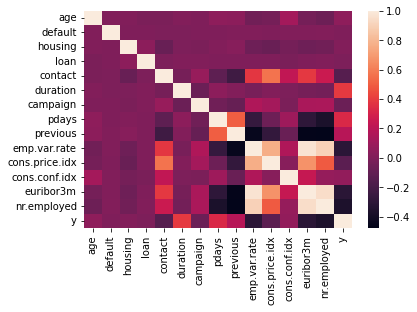

In [23]:
# Display corelation
sns.heatmap(df_corr)

In [24]:
# Have a look the value of correlation and get only columns which has correaltion more than 0.1
columns_check = df.corr()['y'].abs() >= 0.1
for i,j in columns_check.items():
    if j:
        print(i,' : ',  df_corr.loc['y',i].round(2))
    else:
        df.drop(i,axis=1,inplace= True)

contact  :  -0.14
duration  :  0.39
pdays  :  0.33
previous  :  0.19
emp.var.rate  :  -0.31
cons.price.idx  :  -0.13
euribor3m  :  -0.32
nr.employed  :  -0.36
y  :  1.0


From correlation table above, we can see that the most correlated feature of the target is Duration and Pdays column. Let's have a look on the barplot.

<AxesSubplot:xlabel='y', ylabel='duration'>

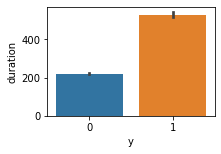

In [25]:
# Duration barplot toward target column
plt.figure(figsize=[3,2])
sns.barplot(data=df, x='y', y='duration')

<AxesSubplot:xlabel='y', ylabel='pdays'>

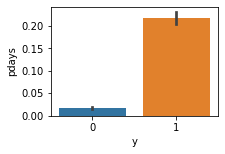

In [26]:
# Pdays barplot toward target column
plt.figure(figsize=[3,2])
sns.barplot(data=df, x='y', y='pdays')

### VI. DATA PREPROCESSING

In [27]:
df.head()

,job,education,contact,month,duration,pdays,previous,emp.var.rate,cons.price.idx,euribor3m,nr.employed,y
0,housemaid,basic.4y,1,may,261,0,0,1.1,93.994,4.857,5191.0,0
2,services,high.school,1,may,226,0,0,1.1,93.994,4.857,5191.0,0
3,admin.,basic.6y,1,may,151,0,0,1.1,93.994,4.857,5191.0,0
4,services,high.school,1,may,307,0,0,1.1,93.994,4.857,5191.0,0
6,admin.,professional.course,1,may,139,0,0,1.1,93.994,4.857,5191.0,0


### VII. MODEL DEFENITION

### VIII. MODEL TRAINING

### IX. MODEL EVALUATION

### X. MODEL INFERENCE

### XI. CONCLUSION